# NonLinearModelV0 with ZeroShotDataset

This notebook is an experimental approach on solving the ARC challenge. See https://arcprize.org/ for more details.

In [1]:
import os
import random

import torch

from pathlib import Path

from arc2024.data import ZeroShotDataset
from arc2024.utils import plot
from arc2024.utils.calc import accuracy_fn, norm_arc20204
from arc2024.models.non_linear import NonLinearModelV0

# Setup Device Agnostic Environment

In [2]:
import arc2024.utils.amdgpu as amd

if amd.is_amdgpu_on_linux():
    # Use ROCm on rx6600/6600xt by setting the environment variable HSA_OVERRIDE_GFX_VERSION to "10.3.0"
    # Source: https://github.com/ROCm/ROCm/issues/1698#issuecomment-1261646854
    amd.setup_amdgpu_environment(
        hsa_override_gfx_version="10.3.0"
    )

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

## Prepare Datasets and DataLoaders

In [3]:
dataset_dir = Path('datasets')

BATCH_SIZE = 32
NUM_WORKERS = os.cpu_count()

train_dataset = ZeroShotDataset(
    dataset_dir=dataset_dir,
    dataset_name='training',
    mode='train',
    permutations=True
)
train_dataloader = torch.utils.data.DataLoader(
    dataset=train_dataset,
    batch_size=BATCH_SIZE,
    shuffle=True,
    num_workers=NUM_WORKERS
)

test_dataset = ZeroShotDataset(
    dataset_dir=dataset_dir,
    dataset_name='training',
    mode='test'
)
test_dataloader = torch.utils.data.DataLoader(
    dataset=test_dataset,
    batch_size=BATCH_SIZE,
    shuffle=True,
    num_workers=NUM_WORKERS
)

## Train Model

In [4]:
model = NonLinearModelV0(
    in_features=900, # 30x30
    hidden_features=600, # do some compression
    out_features=900
).to(device)
model

NonLinearModelV0(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (linear1): Linear(in_features=900, out_features=600, bias=True)
  (relu1): ReLU()
  (linear2): Linear(in_features=600, out_features=900, bias=True)
  (relu2): ReLU()
  (unflatten): Unflatten(dim=1, unflattened_size=(1, 30, 30))
)

### Verify Input and Output Shapes with Random Tensor

In [5]:
x = torch.rand([1, 30, 30]).to(device)
model(x).shape

torch.Size([1, 1, 30, 30])

In [6]:
X, y = train_dataset[0]
X = X.to(device) / 10
y = y.to(device) / 10

y_pred = model(X)
y_pred, y_pred.shape

(tensor([[[[0.1069, 0.3854, 0.0000, 0.4098, 0.1210, 0.0000, 0.1562, 0.0807,
            0.2272, 0.0000, 0.0000, 0.1914, 0.0000, 0.5827, 0.0000, 0.0313,
            0.1255, 0.2811, 0.0000, 0.0000, 0.5345, 0.3176, 0.2530, 0.0444,
            0.2838, 0.0843, 0.1334, 0.0000, 0.0000, 0.0000],
           [0.0000, 0.2763, 0.0000, 0.0000, 0.2061, 0.0761, 0.1901, 0.3553,
            0.0000, 0.2457, 0.0477, 0.2781, 0.1769, 0.1261, 0.0000, 0.3497,
            0.0000, 0.0081, 0.0000, 0.0000, 0.0753, 0.3014, 0.1546, 0.1666,
            0.2409, 0.0000, 0.0022, 0.1400, 0.0000, 0.2593],
           [0.2746, 0.3671, 0.0000, 0.0832, 0.4587, 0.0000, 0.0000, 0.0000,
            0.0000, 0.1088, 0.1320, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
            0.1718, 0.0137, 0.0464, 0.0000, 0.2380, 0.0391, 0.2222, 0.0000,
            0.0283, 0.0000, 0.0000, 0.5568, 0.0000, 0.2862],
           [0.0000, 0.3417, 0.0935, 0.1690, 0.2056, 0.0000, 0.0000, 0.2071,
            0.2083, 0.4023, 0.0000, 0.0365, 0.0938, 0.000

### Setup Loss, optimizer and evaluation metrics

In [7]:
loss_fn = torch.nn.MSELoss()
optimizer = torch.optim.SGD(params=model.parameters(), lr=0.01)

### Run Training Loop

In [8]:
from timeit import default_timer as timer 

epochs = 50

time_start = timer()
for epoch in range(epochs):
    ### Training
    train_loss = 0
    train_accuracy = 0

    model.train() # Set model into training mode
    
    for b, (X_train, y_train) in enumerate(train_dataloader):
        # Send to device and normalize:
        X_train, y_train = X_train.to(device) / 10, y_train.to(device) / 10
        
        # Forward pass:
        train_pred = model(X_train)
        
        # Calculate loss:
        loss = loss_fn(train_pred, y_train)
        train_loss += loss
        train_accuracy += accuracy_fn(y_train, norm_arc20204(train_pred))
        
        # Reset optimizer gradients:
        optimizer.zero_grad()
        
        # Backward pass:
        loss.backward()
        
        # Adjust parameters:
        optimizer.step()

    train_loss /= len(train_dataloader.dataset)
    train_accuracy /= len(train_dataloader.dataset)
    
    ### Testing
    test_loss = 0
    test_accuracy = 0
    model.eval() # set model into evaluation mode

    with torch.inference_mode():
        for X_test, y_test in test_dataloader:
            # Send to device and normalize:
            X_test, y_test = X_test.to(device) / 10, y_test.to(device) / 10

            # Forward pass:
            test_pred = model(X_test)

            # Calculate loss:
            loss = loss_fn(test_pred, y_test)
            test_loss += loss
            test_accuracy += accuracy_fn(y_test, norm_arc20204(test_pred))
    
        test_loss /= len(test_dataloader.dataset)
        test_accuracy /= len(test_dataloader.dataset)
    
    print(f"Epoch {epoch + 1}/{epochs} | Train loss: {train_loss:.5f} | Train accuracy: {train_accuracy:.2f}% | Test loss: {test_loss:.5f} | Test accuracy: {test_accuracy:.2f}%")
time_end = timer()

print(f"Total time taken: {time_end - time_start}")

Epoch 1/50 | Train loss: 0.01399 | Train accuracy: 0.05% | Test loss: 0.01176 | Test accuracy: 0.12%
Epoch 2/50 | Train loss: 0.01148 | Train accuracy: 0.09% | Test loss: 0.01137 | Test accuracy: 0.12%
Epoch 3/50 | Train loss: 0.01119 | Train accuracy: 0.10% | Test loss: 0.01126 | Test accuracy: 0.12%
Epoch 4/50 | Train loss: 0.01112 | Train accuracy: 0.11% | Test loss: 0.01119 | Test accuracy: 0.13%
Epoch 5/50 | Train loss: 0.01105 | Train accuracy: 0.11% | Test loss: 0.01112 | Test accuracy: 0.12%
Epoch 6/50 | Train loss: 0.01101 | Train accuracy: 0.11% | Test loss: 0.01111 | Test accuracy: 0.13%
Epoch 7/50 | Train loss: 0.01100 | Train accuracy: 0.11% | Test loss: 0.01107 | Test accuracy: 0.13%
Epoch 8/50 | Train loss: 0.01094 | Train accuracy: 0.11% | Test loss: 0.01102 | Test accuracy: 0.14%
Epoch 9/50 | Train loss: 0.01090 | Train accuracy: 0.10% | Test loss: 0.01092 | Test accuracy: 0.13%
Epoch 10/50 | Train loss: 0.01078 | Train accuracy: 0.10% | Test loss: 0.01084 | Test accur

# Evaluate Model

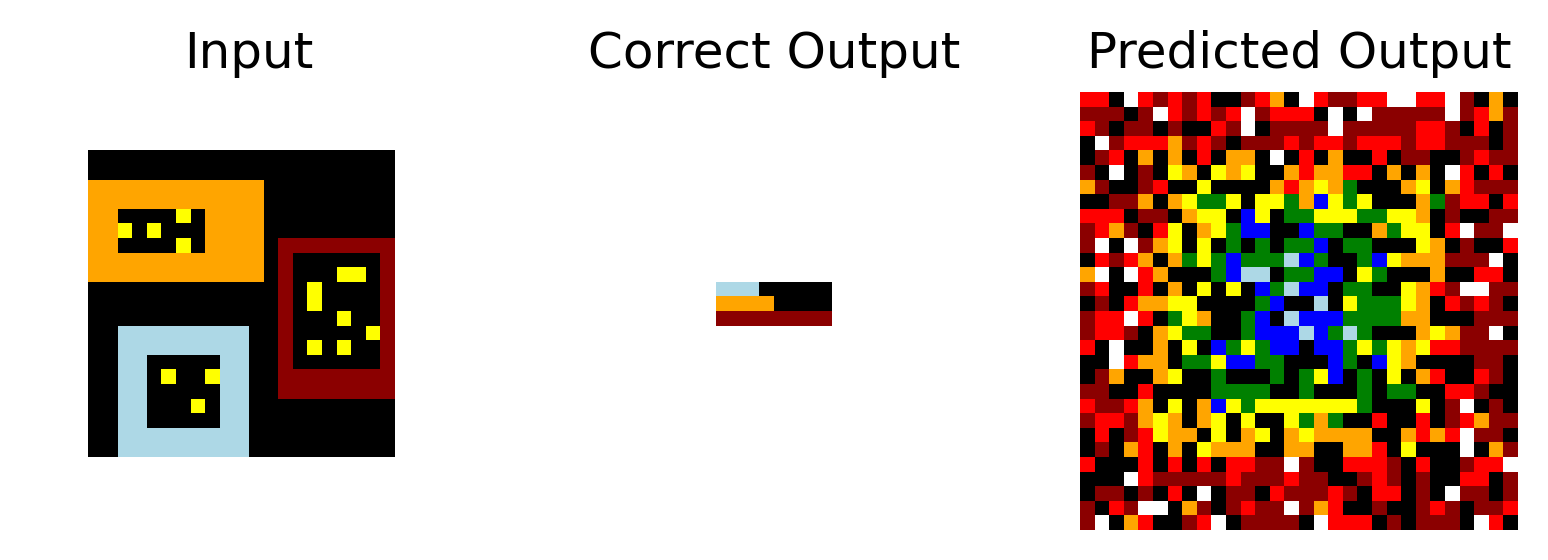

Accuracy: 0.56% (5/900)


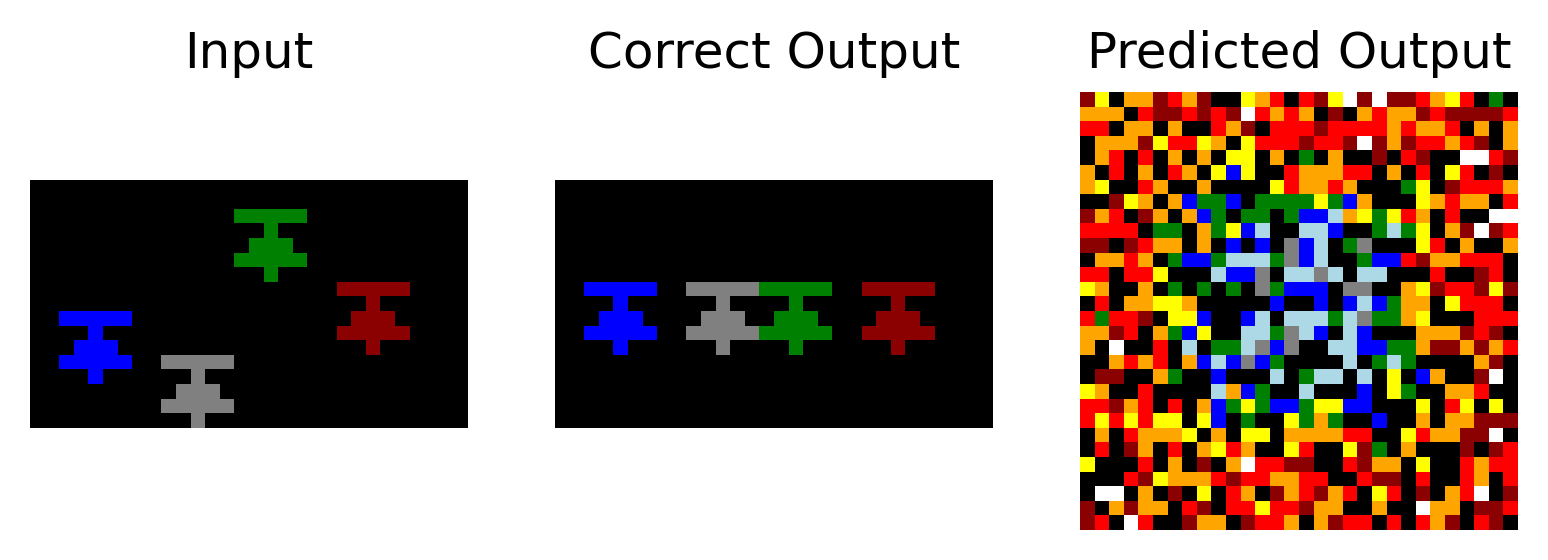

Accuracy: 16.89% (152/900)


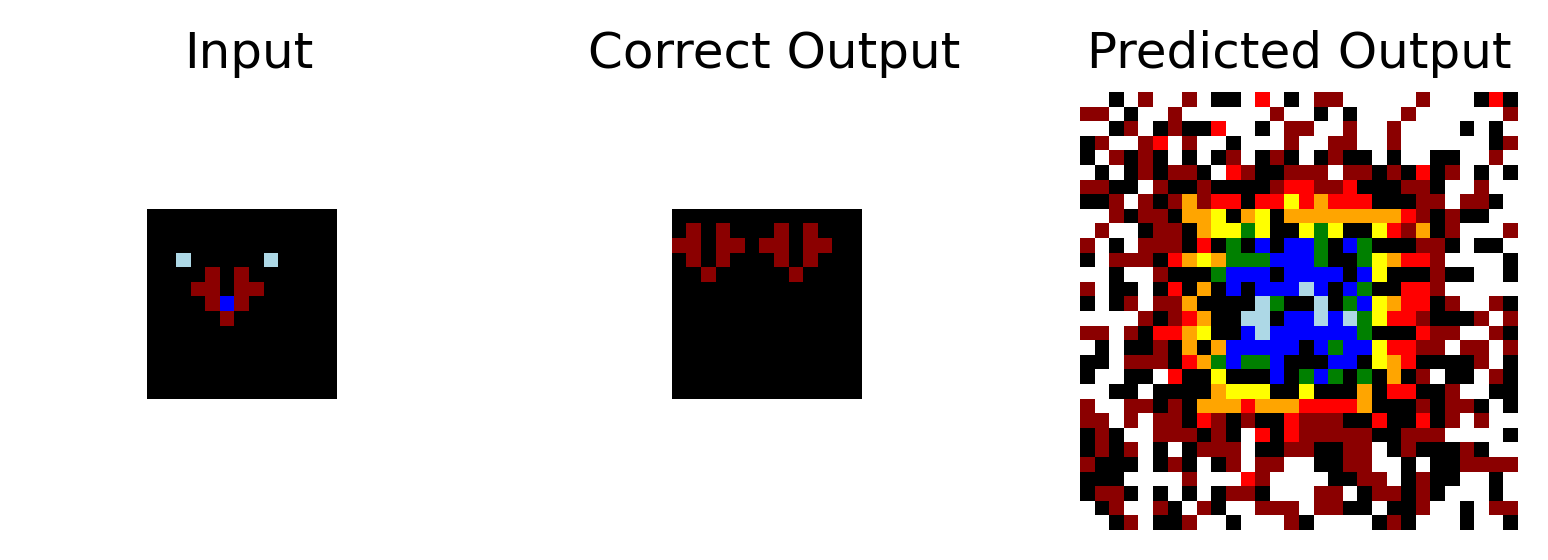

Accuracy: 7.78% (70/900)


In [11]:
evaluations = 3

evaluation_dataset = ZeroShotDataset(
    dataset_dir=dataset_dir,
    dataset_name='evaluation',
    mode='test'
)

model.eval() # set model into evaluation mode
with torch.inference_mode():
    
    for _ in range(evaluations):
        X, y = random.choice(evaluation_dataset)
        X, y = X.to(device) / 10, y.to(device) / 10
        
        y_pred = model(X)[0]
        y_pred_norm = norm_arc20204(y_pred)
        
        plot.input_and_output(X * 10, y * 10, y_pred_norm * 10)
        accuracy_pred = accuracy_fn(y, y_pred_norm)
        print(f"Accuracy: {accuracy_pred:.2f}% ({int(accuracy_pred / 100 * 900)}/900)")
